In [1]:
import os
os.chdir("..")

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from plotnine import ggplot, aes, geom_line, geom_ribbon, facet_wrap, scale_x_log10, labs, coord_cartesian, theme_bw, theme, element_text, guides, guide_legend, scale_color_manual, scale_fill_manual
from production.utils import add_return_periods

Uniform full monte

In [3]:
duwamish_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Duwamish/fullmonte_depths.pq")
kanawha_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Kanawha/fullmonte_depths.pq")
trinity_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/fullmonte_depths.pq")
denton_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/fullmonte_depths.pq")

datasets = {
    "Duwamish": duwamish_fullmonte_depths,
    "Kanawha": kanawha_fullmonte_depths,
    "Trinity": trinity_fullmonte_depths,
    "Denton": denton_fullmonte_depths,
}

In [4]:
# Apply the add_return_periods function to each DataFrame in datasets
datasets = {
   name: add_return_periods(df,
                            rep_col="rep",
                            precip_col="precip_avg_mm",
                            exc_col="exc_prb",
                            k=10.0)
   for name, df in datasets.items()
}
# convert precip to inches at the same time
for name, df in datasets.items():
   df["precip_in"] = df["precip_avg_mm"] / 25.4

In [5]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_ribbon, facet_wrap,
    scale_x_log10, labs, theme, element_text, theme_bw
)

# ---- stack to tidy long df ----
long_df = []
for name, df in datasets.items():
    t = df.copy()
    t["watershed"] = name
    long_df.append(t)
long_df = pd.concat(long_df, ignore_index=True)

# ---- summary: mean, 5th, 95th percentiles per watershed × RP ----
summary = (long_df.groupby(["watershed", "return_period"])["precip_in"]
           .agg(mean="mean",
                p5=lambda x: np.percentile(x, 5),
                p95=lambda x: np.percentile(x, 95))
           .reset_index())

# ---- prepare rep lines ----
rep_lines = long_df.sort_values(["watershed", "rep", "return_period"])

# ---- prepare CI ribbons ----
ci_ribbon = summary.copy()
ci_ribbon = ci_ribbon.rename(columns={"p5": "ymin", "p95": "ymax"})

In [ ]:
kanawha_atlas14 = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/ATLAS14/Kanawha.pq")
trinity_atlas14 = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/ATLAS14/Trinity.pq")
denton_atlas14 = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/ATLAS14/Denton.pq")

#Trinity
conds = [
   (trinity_atlas14["Return period"] >= 2) & (trinity_atlas14["Return period"] <= 50),
   (trinity_atlas14["Return period"] > 50) & (trinity_atlas14["Return period"] <= 200),
   (trinity_atlas14["Return period"] > 200)
]
choices = [0.6, 0.54, 0.5]
trinity_atlas14["ARF"] = np.select(conds, choices, default=np.nan)
trinity_atlas14["adj_precip"] = trinity_atlas14["avg_precip"] * trinity_atlas14["ARF"]

#Denton
conds = [
   (denton_atlas14["Return period"] >= 2) & (denton_atlas14["Return period"] <= 50),
   (denton_atlas14["Return period"] > 50) & (denton_atlas14["Return period"] <= 200),
   (denton_atlas14["Return period"] > 200)
]
choices = [0.87, 0.87, 0.86]
denton_atlas14["ARF"] = np.select(conds, choices, default=np.nan)
denton_atlas14["adj_precip"] = denton_atlas14["avg_precip"] * denton_atlas14["ARF"]

#Kanawha
conds = [
   (kanawha_atlas14["Return period"] >= 2) & (kanawha_atlas14["Return period"] <= 50),
   (kanawha_atlas14["Return period"] > 50) & (kanawha_atlas14["Return period"] <= 200),
   (kanawha_atlas14["Return period"] > 200)
]
choices = [0.65, 0.59, 0.57]
kanawha_atlas14["ARF"] = np.select(conds, choices, default =np.nan)
kanawha_atlas14["adj_precip"] = kanawha_atlas14["avg_precip"] * kanawha_atlas14["ARF"]      

atlas14 = {
    "Kanawha": kanawha_atlas14,
    "Trinity": trinity_atlas14,
    "Denton": denton_atlas14,
}

# Combine all ATLAS14 datasets into one tidy DataFrame
atlas14_df = pd.concat(atlas14.values(), ignore_index=True)
atlas14_df = atlas14_df.rename(columns={"Return period": "return_period", "avg_precip": "precip_in"})
atlas14_df = atlas14_df[atlas14_df["bound"] == "mean"]  # optional: filter to mean bound

atlas14_df["source"] = "ATLAS14"

/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_color_manual can return a maximum of 2 values. 3 were requested from it.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:45: PlotnineWarning: The palette of scale_color_manual can return a maximum of 2 values. 3 were requested from it.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/themes/themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


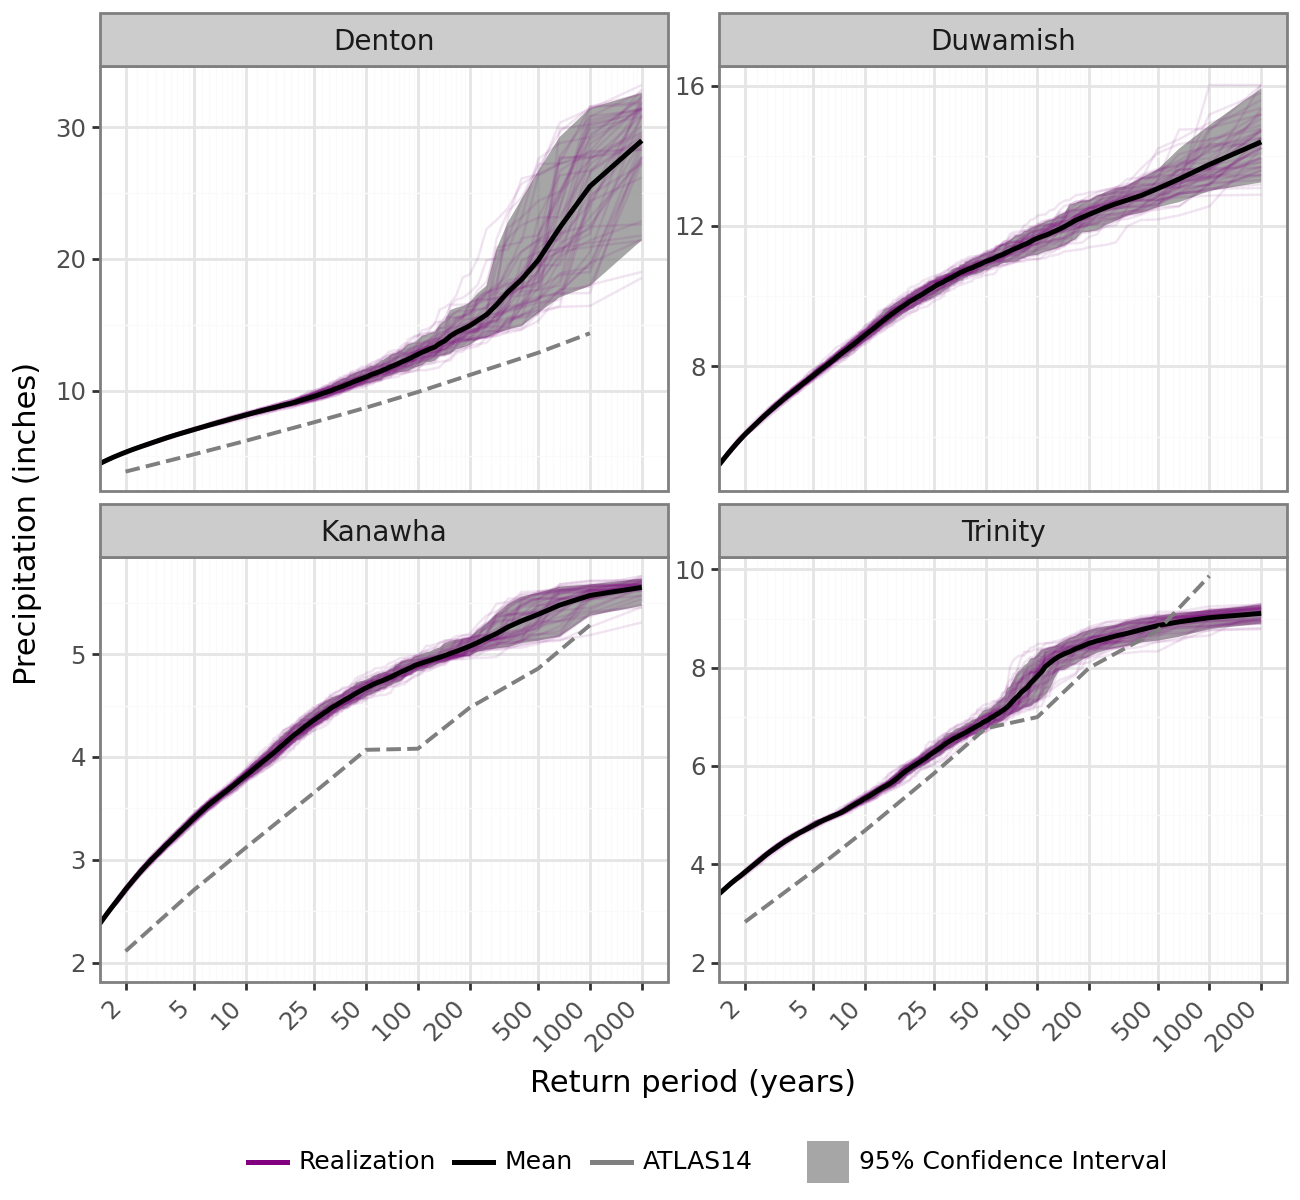

In [43]:
# Define manual y-minimums per watershed
y_mins = {
    "Denton": 4,
    "Duwamish": 5,
    "Kanawha": 2,
    "Trinity": 2
}

# Filter each dataset before plotting
rep_filtered = rep_lines.copy()
ci_filtered = ci_ribbon.copy()
summary_filtered = summary.copy()

rep_filtered = rep_filtered[rep_filtered.apply(lambda row: row["precip_in"] >= y_mins[row["watershed"]], axis=1)]
ci_filtered = ci_filtered[ci_filtered.apply(lambda row: row["ymin"] >= y_mins[row["watershed"]], axis=1)]
summary_filtered = summary_filtered[summary_filtered.apply(lambda row: row["mean"] >= y_mins[row["watershed"]], axis=1)]

rep_filtered["source"] = "Realization"
summary_filtered["source"] = "Mean"
ci_filtered["source"] = "95% Confidence Interval"

p = (
    ggplot()
    + geom_ribbon(data=ci_filtered,
                  mapping=aes(x="return_period", ymin="ymin", ymax="ymax", fill="source"),
                  alpha=0.7)
    + geom_line(data=rep_filtered,
                mapping=aes(x="return_period", y="precip_in", group="rep", color="source"),
                alpha=0.1, size=0.5)
    + geom_line(data=summary_filtered,
                mapping=aes(x="return_period", y="mean", color="source"),
                size=1)
    + geom_line(data=atlas14_df,
                mapping=aes(x="return_period", y="adj_precip", color="source"),
                linetype="dashed", size=0.8)
    + facet_wrap("~watershed", ncol=2, scales="free_y")
    + scale_x_log10(breaks=[2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000])
    + labs(x="Return period (years)", y="Precipitation (inches)", color="", fill="")
    + coord_cartesian(xlim=(2, 2000))
    + theme_bw()
    + theme(
        subplots_adjust={'wspace': 0.25},
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(6.5, 6),
        strip_text=element_text(size=10),
        legend_position='bottom',
        legend_direction='horizontal',
        legend_title=element_text(size=10),
        legend_text=element_text(size=9)
    )
    + scale_color_manual(values={
        "Mean": "black",
        "Realization": "purple"
    })
    + scale_fill_manual(values={
        "95% Confidence Interval": "gray"
    })
    + guides(
        color=guide_legend(override_aes={"alpha": 1, "size": 1}),
        fill=guide_legend(override_aes={"alpha": 0.7})
    )
)

p


In [19]:
p.save("/workspaces/Importance-Sampling-for-SST/data/2_production/plots/full_monte_precip_frequency.png", dpi=300, width=6.5, height=6, units="in")

/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.5 x 6 in image.
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspaces/Importance-Sampling-for-SST/data/2_production/plots/full_monte_precip_frequency.png
/opt/conda/envs/mbi-base/lib/python3.11/site-packages/plotnine/themes/themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.
